In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [165]:
from keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from keras import backend, models, layers, optimizers
from keras.layers import Dense, Flatten

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy

from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

from PIL import Image
from keras.preprocessing import image

In [3]:
# Construct the path to each desired file
base_path = "input/"

train_dir = base_path + "train/"
valid_dir = base_path + "valid/"
test_dir = base_path + "test/"

# Data will flow through this generator and will normalize
#train_datagen = ImageDataGenerator(rescale=1./255) Included later for the purpose of data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
from tensorflow.keras.applications import ResNet50V2

In [5]:
resnet_base = ResNet50V2(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224, 224, 3))

In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=40,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    fill_mode='nearest')

In [116]:
# Moves data from their respective directories to the model
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

valid_gen = train_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=25,
    shuffle=False,
    class_mode="categorical")

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


In [18]:
resnet_base.trainable = True

# Setting trainable layers within transfer learning base model
for layer in resnet_base.layers[:-5]:
  layer.trainable = False
for layer in resnet_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f22c461c910> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f22401ca520> False
<keras.layers.convolutional.Conv2D object at 0x7f22401ca8e0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f22401ca8b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f223f93abb0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223f8f5130> False
<keras.layers.core.activation.Activation object at 0x7f223c689250> False
<keras.layers.convolutional.Conv2D object at 0x7f223c6bb940> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223c689ca0> False
<keras.layers.core.activation.Activation object at 0x7f223c6bb9d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f223c6a5c70> False
<keras.layers.convolutional.Conv2D object at 0x7f223c650a60> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223c650b20> Fals

In [30]:
backend.clear_session()

# Model Creation
inputs = Input(shape=(224,224,3))
resnet_conv = resnet_base(inputs)
flatten_1 = layers.Flatten()(resnet_conv)
drop_1 = Dropout(0.3)(flatten_1)
dense_1 = layers.Dense(1024, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(drop_1)
batch_1 = BatchNormalization()(dense_1)
dense_2 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(batch_1)
dense_3 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(dense_2)
outputs = layers.Dense(315, activation='softmax')(dense_2)

In [31]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    min_delta=0.001, 
    mode='max'
)

In [32]:
model_resnet = Model(inputs=inputs, outputs=outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model_resnet.fit(train_gen,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_gen,
                       validation_steps = 50,
                       callbacks=[custom_early_stopping])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

Epoch 1/100
100/100 [==============================] - 186s 2s/step - loss: 7.1893 - accuracy: 0.1385 - val_loss: 5.6424 - val_accuracy: 0.3360
Epoch 2/100
100/100 [==============================] - 156s 2s/step - loss: 5.4267 - accuracy: 0.3960 - val_loss: 4.2180 - val_accuracy: 0.5900
Epoch 3/100
100/100 [==============================] - 131s 1s/step - loss: 4.5309 - accuracy: 0.5470 - val_loss: 3.5521 - val_accuracy: 0.6970
Epoch 4/100
100/100 [==============================] - 126s 1s/step - loss: 3.9847 - accuracy: 0.6450 - val_loss: 3.2597 - val_accuracy: 0.7550
Epoch 5/100
100/100 [==============================] - 125s 1s/step - loss: 3.6808 - accuracy: 0.6885 - val_loss: 3.0537 - val_accuracy: 0.7940
Epoch 6/100
100/100 [==============================] - 141s 1s/step - loss: 3.4903 - accuracy: 0.7200 - val_loss: 2.9797 - val_accuracy: 0.7910
Epoch 7/100
100/100 [==============================] - 132s 1s/step - loss: 3.2718 - accuracy: 0.7605 - val_loss: 2.8225 - val_accuracy:

100/100 [==============================] - 130s 1s/step - loss: 2.1084 - accuracy: 0.9005 - val_loss: 2.0203 - val_accuracy: 0.9190
Epoch 58/100
100/100 [==============================] - 141s 1s/step - loss: 2.1081 - accuracy: 0.8980 - val_loss: 1.9914 - val_accuracy: 0.9260
Epoch 59/100
100/100 [==============================] - 129s 1s/step - loss: 2.1427 - accuracy: 0.8800 - val_loss: 2.0243 - val_accuracy: 0.9110
Epoch 60/100
100/100 [==============================] - 135s 1s/step - loss: 2.1599 - accuracy: 0.8765 - val_loss: 2.0209 - val_accuracy: 0.9080
Epoch 61/100
100/100 [==============================] - 138s 1s/step - loss: 2.0968 - accuracy: 0.8940 - val_loss: 1.9861 - val_accuracy: 0.9130
Epoch 62/100
100/100 [==============================] - 125s 1s/step - loss: 2.0652 - accuracy: 0.9060 - val_loss: 1.9696 - val_accuracy: 0.9200
Epoch 63/100
100/100 [==============================] - 126s 1s/step - loss: 2.1303 - accuracy: 0.8790 - val_loss: 2.0214 - val_accuracy: 0.911

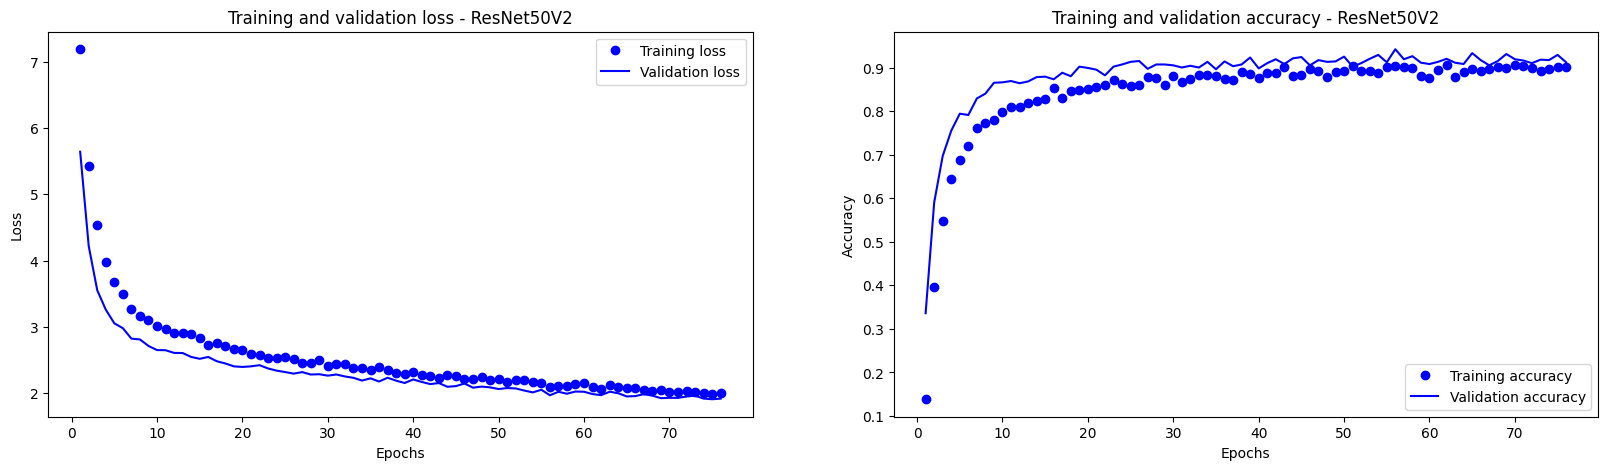

In [33]:
# Plotting Training accuracy vs Validation accuracy for comparison
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50V2')
plt.xlabel('Epochs')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
resnet_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [117]:
test_loss, test_accuracy = model_resnet.evaluate(test_gen)
print('Test Accuracy: ' + str(test_accuracy))

63/63 [==============================] - 38s 596ms/step - loss: 1.7929 - accuracy: 0.9524
Test Accuracy: 0.9523809552192688


In [136]:
model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                             

## Model Discussion

This model passed the goal of 95% accuracy for the model. This shows good performance for such short training time. Better results would be better with more time for tuning hyperparameters. However, the time limit set on this project of one week produced a promising result. The Kaggle dataset page states that a model in the mid to upper 90% for accuracy is moderately robust. This is a target which was met.

I will now discuss my decisions on the model.

### Data Augmentation

For data augmentation, there was not much that I felt was possible to do. Many of the images (which can be viewed below and in the dataset as well, and can be seen discussed on the Kaggle dataset page) are already rather edited to focus on the bird in the image. This resulted in images were there was little room around the image for shear and shift augmentation. The presence of these techniques reduced the model accuracy due to the loss of information. Parts of the birds were being removed. This restricted data augmentation to rotating and flipping the image. This did result in better model performance.

### Model

The model performance in relation to the training and validation sets are curious, but not surprising. Due to dropout, the model performed better on the validation set rather than the training set. This is curious because the training set is what is being used for tuning the parameters, not the validation set. One would expect the results to be reversed while fitting the model.

This conflict occurs due to the regularization and batch normalization introduced in the Dense layers, which lower the chance of overfitting. This allows the two lines to follow one another more closely. In addition to this, the introduction of dropout lowers the training results in order for better tuning of the layers in the model.

My one concern of introducing all of these techniques throughout the model is that there might be some loss of information. This results from constantly recalibrating the inputs and outputs of each layers. This coudl result in lower accuracy, but I restricted some of these techniques to one use, or a certain version. I used dropout and batchnormalization once, while L2 regularization was used in place of L1 regularization because it poses less risk for information loss and has statistically performed better.

## Future Improvements

### Model Improvements

More time to fine-tune hyperparameters for the current layers and regularization techniques would certainly produce better results.

Because of the high variance of neural networks, an ensemble of neural networks could possibly improve consistency and accuracy of the model. However, the lower learning rate minimized the variance of the model's results, achieving the same 95.24% accuracy on the test data in multiple reruns of the model and evaluation.

ResNet50V2 showed good results, and with more time I would have tested the InceptionV3 model. Both models were similar in model selection (ModelSelection.ipynb). This could possibly have improved on the results as well.

It is also possible that setting more trainable layers would have aided in tuning the model to this specific dataset as well. A majority of the parameters are not set to be trainable. However, this is not certain, because over 22-million parameters out of 127-million are still set to be trainable.

Another way to introduce more trainable parameters would be to increase the number of nodes in the Dense input and hidden layers. While this has generally produced better results for me, the training time for this model was already lengthy due to limited resources, limited time, and bugs with WL2 which prevented gpu support. This is an issue I hope to figure out in the future.

## Model Analysis

In [130]:
# collection of predicted classes and their image
test_gen.reset()
pred = model_resnet.predict(test_gen)
predictions = np.argmax(pred, axis=-1)

# Collection of test images and classes
actual = test_gen.classes

# Class list
class_labels = list(test_gen.class_indices.keys())

In [170]:
# Collecting Wrong Prediction information
indices = [i for i,v in enumerate(pred) if predictions[i]!=actual[i]]

In [171]:
# Collection of wrongly predicted labels
wrong_labels = {}
for i in indices:
    if predictions[i] not in wrong_labels:
        wrong_labels[predictions[i]] = 1
    else:
        wrong_labels[predictions[i]] += 1
        
true_labels = {}
for i in indices:
    if actual[i] not in true_labels:
        true_labels[actual[i]] = 1
    else:
        true_labels[actual[i]] += 1

In [172]:
print("Number of Classes with at least one image attributed to it through wrong prediction: " + str(len(wrong_labels)))
print("Number of Classes with at least one image wrongly predicted: " + str(len(true_labels)))
print("Number of wrong predictions: " + str(len(indices)))

Number of Classes with at least one image attributed to it through wrong prediction: 60
Number of Classes with at least one image wrongly predicted: 64
Number of wrong predictions: 75


In [182]:
# Collection of class index for wrongly predicted labels
true_label_list = [actual[i] for i in indices]
wrong_label_list = [predictions[i] for i in indices]

# Collection of class names for wrongly predicted labels
true_classes = [class_labels[i] for i in true_label_list]
wrong_classes = [class_labels[i] for i in wrong_label_list]

In [181]:
len(true_classes)

75

In [174]:
# List of Test Images
image_list = []

for i in range(0,len(class_labels)-1):
    class_name = class_labels[i]
    
    class_images = os.listdir('input/test/' + class_name)
    for j in class_images:
        img = Image.open("input/test/" + class_name + "/" + j)
        image_list.append(img)

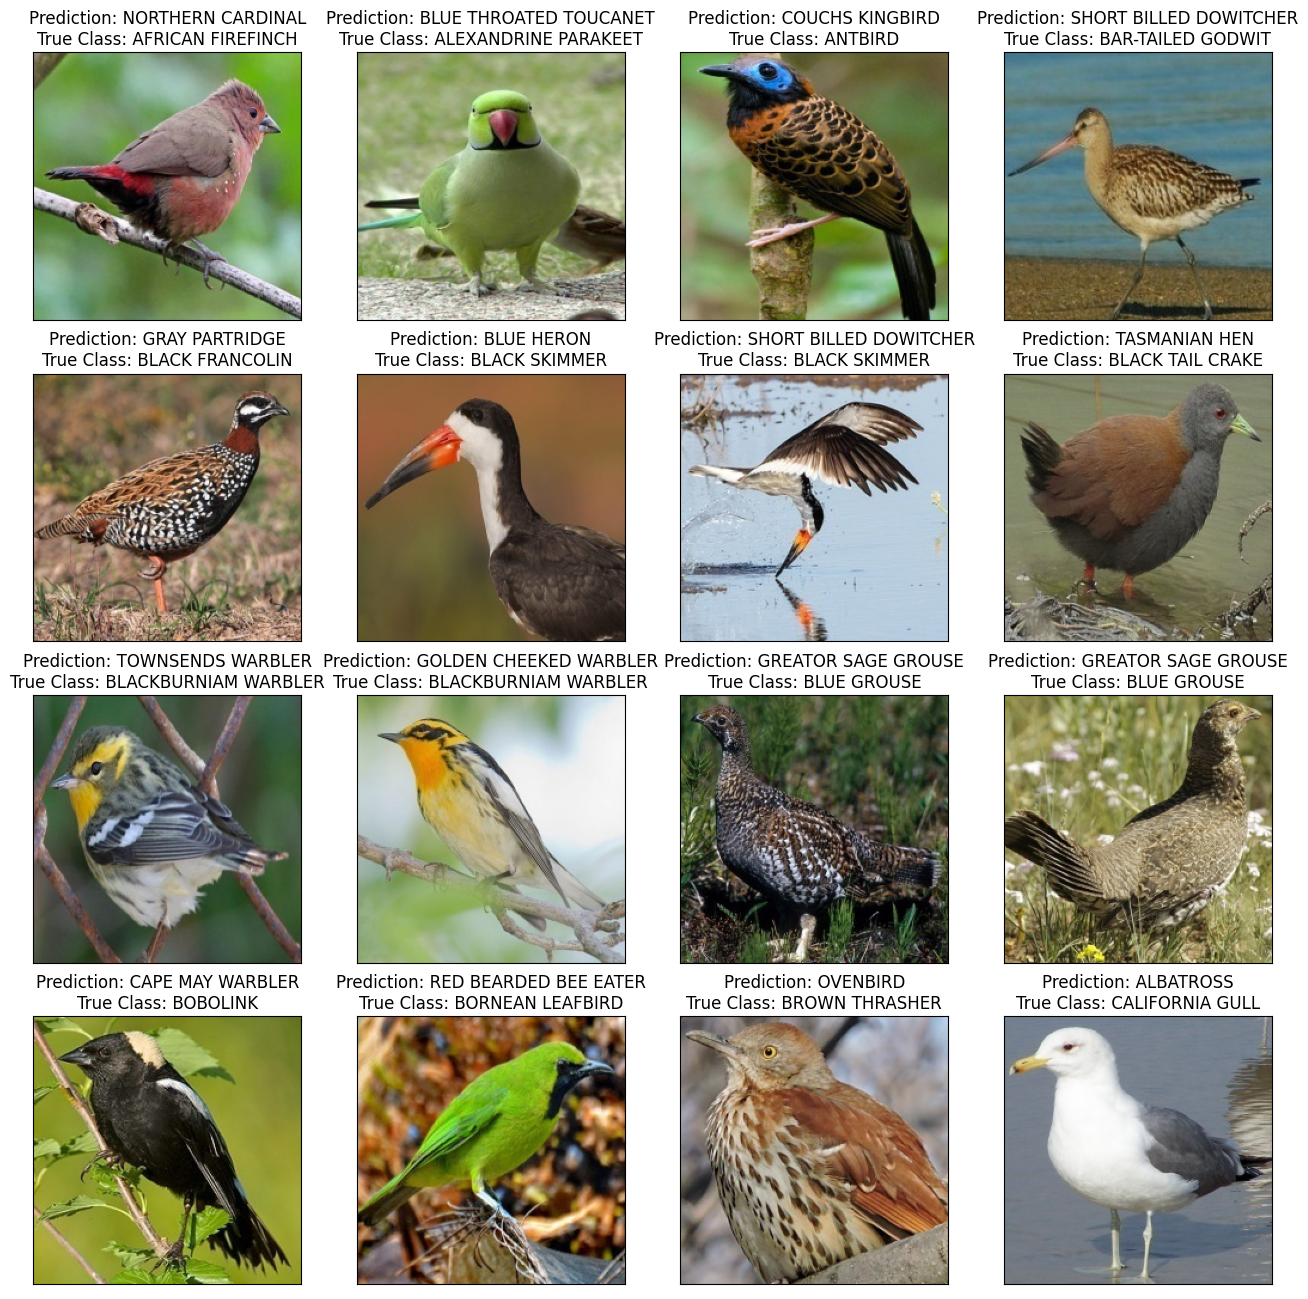

In [183]:
plt.figure(figsize=(16,16))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_list[indices[i]])
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction: ' + wrong_classes[i] + "\n" + "True Class: " + true_classes[i] )
    
plt.show()

## Final Words

The above images demonstrate some of the areas of shortcomings in this model. The main one, is color. Many of these predictions share the same shapes as those which the model predicted, but contain slightly different colours. In the case fo the California Gull, the Albatross as a slightly different colour in the head area. Similarly, the Red Bearded Bee Eater has red colours in the place of the black of the Bornean Leafbird.

Possible reasons for this include possible over-indulgence in regularization and normalization, unbalanced data for the female to male ratio for bird images (male birds tend to be more colourful), and a smaller dataset per class than is optimal. Data Augmentation attempts to solve the final two problems mentioned, while the first listed is discussed breifly above.

Overall, I am happy with the model performance with the limitations I had set for myself, and learned a lot from this assignment. Some of the knowledge gained during my time in MSDS 686 - Deep Learning helped tremendously in building a model with good performance quickly. This allowed me to have more time in fine-tuning the architecture I had decided on than reconfiguring the model itself. This includes the number of nodes and layers, use of regularization techniques, reading loss/accuracy graphs, and much more.